In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor, XGBRFRegressor

In [2]:
diamond_train = pd.read_csv('/kaggle/input/diamond-price-perdiction/train.csv')

In [3]:
diamond_train.head()

,Id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,1.06,Ideal,I,SI2,61.8,57.0,4270,6.57,6.60,4.07
1,2,1.51,Premium,G,VVS2,60.9,58.0,15164,7.38,7.42,4.51
2,3,0.32,Ideal,F,VS2,61.3,56.0,828,4.43,4.41,2.71
3,4,0.53,Ideal,G,VS2,61.2,56.0,1577,5.19,5.22,3.19
4,5,0.70,Premium,H,VVS2,61.0,57.0,2596,5.76,5.72,3.50


In [4]:
diamond_train.shape

(43152, 11)

In [5]:
diamond_train.columns

Index(['Id', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price',
       'x', 'y', 'z'],
      dtype='object')

In [6]:
diamond_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43152 entries, 0 to 43151
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Id       43152 non-null  int64  
 1   carat    43152 non-null  float64
 2   cut      43152 non-null  object 
 3   color    43152 non-null  object 
 4   clarity  43152 non-null  object 
 5   depth    43152 non-null  float64
 6   table    43152 non-null  float64
 7   price    43152 non-null  int64  
 8   x        43152 non-null  float64
 9   y        43152 non-null  float64
 10  z        43152 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 3.6+ MB


In [7]:
diamond_train.describe()

,Id,carat,depth,table,price,x,y,z
count,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000
mean,21576.500000,0.797855,61.747177,57.458347,3929.491912,5.731568,5.735018,3.538568
std,12457.053745,0.473594,1.435454,2.233904,3985.527795,1.121279,1.148809,0.708238
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,10788.750000,0.400000,61.000000,56.000000,947.750000,4.710000,4.720000,2.910000
50%,21576.500000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,32364.250000,1.040000,62.500000,59.000000,5312.000000,6.540000,6.540000,4.040000
max,43152.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [8]:
diamond_train.isnull().sum()

Id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [9]:
# function to remove outlires
def remove_outlires(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    IQR = q3 - q1
    outlires = df[~((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    new_df = outlires.dropna().reset_index()
    return new_df

In [10]:
# Get new feature 'volume' by multiply the dimensions x, y and z
diamond_train['volume'] = diamond_train['x'] * diamond_train['y'] * diamond_train['z']
diamond_train = diamond_train.drop(['x','y','z'], axis=1)
diamond_train.head()

,Id,carat,cut,color,clarity,depth,table,price,volume
0,1,1.06,Ideal,I,SI2,61.8,57.0,4270,176.483340
1,2,1.51,Premium,G,VVS2,60.9,58.0,15164,246.965796
2,3,0.32,Ideal,F,VS2,61.3,56.0,828,52.943373
3,4,0.53,Ideal,G,VS2,61.2,56.0,1577,86.422842
4,5,0.70,Premium,H,VVS2,61.0,57.0,2596,115.315200


In [11]:
# delete the rows that has volume = 0
diamond_train = diamond_train.drop(diamond_train.index[diamond_train['volume'] == 0], axis=0)

In [12]:
# convert the non-numerical columns to numerical columns
categorical_columns = diamond_train.select_dtypes(exclude  =['number']).columns.tolist()
diamondCopy = diamond_train.copy()
labelEncoder = LabelEncoder()
for col in categorical_columns:
    diamondCopy[col] = labelEncoder.fit_transform(diamondCopy[col])

In [13]:
diamondCopy = remove_outlires(diamondCopy)

In [14]:
diamondCopy.head()

,index,Id,carat,cut,color,clarity,depth,table,price,volume
0,0,1,1.06,2.0,5,3,61.8,57.0,4270.0,176.483340
1,2,3,0.32,2.0,2,5,61.3,56.0,828.0,52.943373
2,3,4,0.53,2.0,3,5,61.2,56.0,1577.0,86.422842
3,4,5,0.70,3.0,4,7,61.0,57.0,2596.0,115.315200
4,5,6,0.90,4.0,3,1,63.1,58.0,5670.0,145.652094


In [15]:
diamondCopy.shape

(37727, 10)

In [16]:
diamondCopy.corr()

,index,Id,carat,cut,color,clarity,depth,table,price,volume
index,1.000000,1.000000,-0.004791,0.003620,-0.015818,-0.002308,0.000120,-0.003130,-0.003709,-0.004891
Id,1.000000,1.000000,-0.004791,0.003620,-0.015818,-0.002308,0.000120,-0.003130,-0.003709,-0.004891
carat,-0.004791,-0.004791,1.000000,0.075299,0.258047,-0.214234,0.026540,0.187167,0.923338,0.998886
cut,0.003620,0.003620,0.075299,1.000000,0.006561,-0.011004,-0.146659,0.323812,0.059237,0.073413
color,-0.015818,-0.015818,0.258047,0.006561,1.000000,-0.013422,0.044923,0.016188,0.140857,0.257697
clarity,-0.002308,-0.002308,-0.214234,-0.011004,-0.013422,1.000000,-0.037651,-0.078063,-0.065860,-0.212619
depth,0.000120,0.000120,0.026540,-0.146659,0.044923,-0.037651,1.000000,-0.252210,0.001892,0.012075
table,-0.003130,-0.003130,0.187167,0.323812,0.016188,-0.078063,-0.252210,1.000000,0.137448,0.174986
price,-0.003709,-0.003709,0.923338,0.059237,0.140857,-0.065860,0.001892,0.137448,1.000000,0.924256
volume,-0.004891,-0.004891,0.998886,0.073413,0.257697,-0.212619,0.012075,0.174986,0.924256,1.000000


<Axes: >

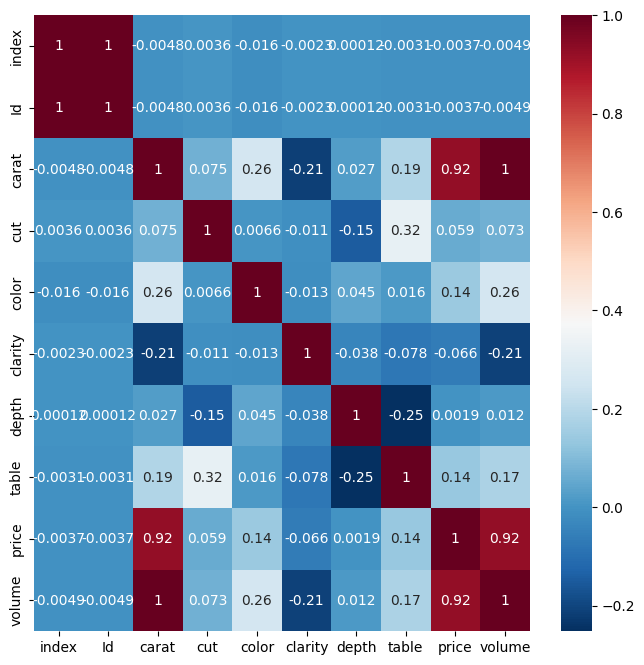

In [17]:
plt.subplots(figsize=(8,8))
sns.heatmap(diamondCopy.corr(), annot=True, cmap='RdBu_r')

In [18]:
# set the dataset in preparation for splitting
x = diamondCopy.drop(['price'], axis = 1 )
y = diamondCopy['price']

In [19]:
# split the dataset for training and testing
x_train, x_test, y_train, y_test = train_test_split(x , y  , test_size = 0.2 , random_state = 42)

In [20]:
# models that we will try it
names = ["Linear Regression", "Ridge Regression", "Lasso Regression",
         "Decision Tree Regressor", "Random Forest Regressor", "Gradient Boosting Regressor",
         "Adaboost Regressor", "BaggingRegressor", "ExtraTreesRegressor","XGBRegressor", "XGBRFRegressor"]
models = [LinearRegression(), Ridge(), Lasso(), DecisionTreeRegressor(),
          RandomForestRegressor(), GradientBoostingRegressor(), 
          AdaBoostRegressor(), BaggingRegressor(), ExtraTreesRegressor(),XGBRegressor(), XGBRFRegressor()]

In [21]:
MAE = []
MSE = []
RMSE = []
R_Square = []
CV = []

In [22]:
# function to print the evaluation
def print_evaluate(name, y, model, pred):
    mae = metrics.mean_absolute_error(y, pred)
    mse = metrics.mean_squared_error(y, pred)
    rmse = np.sqrt(metrics.mean_squared_error(y, pred))
    r_square = metrics.r2_score(y, pred)
    print("MAE:", mae)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("R2 Square", r_square)

In [23]:
# function to evalute the model that we try it
def evaluate(name, y, pred, model):
    MAE.append(metrics.mean_absolute_error(y, pred))
    MSE.append(metrics.mean_squared_error(y, pred))
    RMSE.append(np.sqrt(metrics.mean_squared_error(y, pred)))
    R_Square.append(metrics.r2_score(y, pred))
    cv_accuracies = cross_val_score(estimator = model, X = x_train, y = y_train.ravel(), cv = 5,verbose = 1)
    CV.append(cv_accuracies.mean())
    print_evaluate(name, y, model, pred)
    

In [24]:
# function to predict the result
def predict(name, model):
    model.fit(x_train, y_train.ravel())
    pred = model.predict(x_test)
    evaluate(name, y_test, pred, model)

In [25]:
for name, model in zip(names, models):
    predict(name, model)

/tmp/ipykernel_18/2051342522.py:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  model.fit(x_train, y_train.ravel())
/tmp/ipykernel_18/3909948551.py:7: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  cv_accuracies = cross_val_score(estimator = model, X = x_train, y = y_train.ravel(), cv = 5,verbose = 1)
/tmp/ipykernel_18/2051342522.py:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  model.fit(x_train, y_train.ravel())
/tmp/ipykernel_18/3909948551.py:7: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  cv_accuracies =

MAE: 645.0273060094701
MSE: 874412.2388021386
RMSE: 935.1001223409922
R2 Square 0.8832704418899685
MAE: 644.805326136063
MSE: 874034.4667806386
RMSE: 934.8981050256966
R2 Square 0.8833208725211734


/tmp/ipykernel_18/2051342522.py:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  model.fit(x_train, y_train.ravel())
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.447e+08, tolerance: 2.277e+07
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_18/3909948551.py:7: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  cv_accuracies = cross_val_score(estimator = model, X = x_train, y = y_train.ravel(), cv = 5,verbose = 1)
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarnin

MAE: 644.0432701047147
MSE: 873415.1680335357
RMSE: 934.5668344391083
R2 Square 0.8834035457339665


/tmp/ipykernel_18/3909948551.py:7: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  cv_accuracies = cross_val_score(estimator = model, X = x_train, y = y_train.ravel(), cv = 5,verbose = 1)


MAE: 279.2239597137556
MSE: 248619.47601378214
RMSE: 498.61756488694033
R2 Square 0.9668105725368247


/tmp/ipykernel_18/2051342522.py:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  model.fit(x_train, y_train.ravel())
/tmp/ipykernel_18/3909948551.py:7: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  cv_accuracies = cross_val_score(estimator = model, X = x_train, y = y_train.ravel(), cv = 5,verbose = 1)


MAE: 207.2766379538828
MSE: 130840.35969476544
RMSE: 361.71861950246
R2 Square 0.982533481700748


/tmp/ipykernel_18/2051342522.py:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  model.fit(x_train, y_train.ravel())
/tmp/ipykernel_18/3909948551.py:7: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  cv_accuracies = cross_val_score(estimator = model, X = x_train, y = y_train.ravel(), cv = 5,verbose = 1)


MAE: 258.6152895445543
MSE: 190502.90721517973
RMSE: 436.4663872684582
R2 Square 0.9745688369957318


/tmp/ipykernel_18/2051342522.py:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  model.fit(x_train, y_train.ravel())
/tmp/ipykernel_18/3909948551.py:7: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  cv_accuracies = cross_val_score(estimator = model, X = x_train, y = y_train.ravel(), cv = 5,verbose = 1)


MAE: 620.9747307520191
MSE: 703108.5252798626
RMSE: 838.5156678797734
R2 Square 0.9061386108093052


/tmp/ipykernel_18/2051342522.py:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  model.fit(x_train, y_train.ravel())
/tmp/ipykernel_18/3909948551.py:7: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  cv_accuracies = cross_val_score(estimator = model, X = x_train, y = y_train.ravel(), cv = 5,verbose = 1)


MAE: 218.13384574609066
MSE: 143611.7435515505
RMSE: 378.9614011367787
R2 Square 0.9808285673275247


/tmp/ipykernel_18/2051342522.py:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  model.fit(x_train, y_train.ravel())
/tmp/ipykernel_18/3909948551.py:7: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  cv_accuracies = cross_val_score(estimator = model, X = x_train, y = y_train.ravel(), cv = 5,verbose = 1)


MAE: 205.4425152398622
MSE: 127759.27077336337
RMSE: 357.43428874880397
R2 Square 0.9829447913008807


/tmp/ipykernel_18/2051342522.py:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  model.fit(x_train, y_train.ravel())
/tmp/ipykernel_18/3909948551.py:7: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  cv_accuracies = cross_val_score(estimator = model, X = x_train, y = y_train.ravel(), cv = 5,verbose = 1)


MAE: 203.0552815453241
MSE: 124635.18103394684
RMSE: 353.0370816698252
R2 Square 0.9833618412901144


/tmp/ipykernel_18/2051342522.py:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  model.fit(x_train, y_train.ravel())
/tmp/ipykernel_18/3909948551.py:7: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  cv_accuracies = cross_val_score(estimator = model, X = x_train, y = y_train.ravel(), cv = 5,verbose = 1)


MAE: 351.2356624244348
MSE: 362473.16675112554
RMSE: 602.0574447269342
R2 Square 0.9516116875953553


In [26]:
evaluation = pd.DataFrame({"Model": names,
                           "MAE": MAE,
                           "MSE": MSE,
                           "RMSE": RMSE,
                           "R2 Squared": R_Square,
                           "Cross Validation": CV})

In [27]:
evaluation = evaluation.sort_values("R2 Squared")

In [28]:
evaluation

,Model,MAE,MSE,RMSE,R2 Squared,Cross Validation
0,Linear Regression,645.027306,874412.238802,935.100122,0.883270,0.884561
1,Ridge Regression,644.805326,874034.466781,934.898105,0.883321,0.884553
2,Lasso Regression,644.043270,873415.168034,934.566834,0.883404,0.884256
6,Adaboost Regressor,620.974731,703108.525280,838.515668,0.906139,0.897103
10,XGBRFRegressor,351.235662,362473.166751,602.057445,0.951612,0.952409
3,Decision Tree Regressor,279.223960,248619.476014,498.617565,0.966811,0.963972
5,Gradient Boosting Regressor,258.615290,190502.907215,436.466387,0.974569,0.973686
7,BaggingRegressor,218.133846,143611.743552,378.961401,0.980829,0.979158
4,Random Forest Regressor,207.276638,130840.359695,361.718620,0.982533,0.981026
8,ExtraTreesRegressor,205.442515,127759.270773,357.434289,0.982945,0.981306
